# Uncertainty Prediction

We often consider model confidence to avoid making costly mistakes when making decisions based on model predictions. Two types of uncertainty can be introduced to our models. Aleatoric uncertainty is irreducible and stems from the random data generation process (for example, inaccurate measurements). The lack of relevant data causes epistemic uncertainty and can be fixed by generating more data points.

![uncertainty](uncertainty.png)

<span style="font-size: 8pt">source: https://towardsdatascience.com/my-deep-learning-model-says-sorry-i-dont-know-the-answer-that-s-absolutely-ok-50ffa562cb0b</span>

## Conformal Prediction

One uncertainty prediction method that is agnostic to the selected machine learning model is conformal prediction. It's a method based on statistical testing that instead of returning point-predictions (one value), it predicts set-predictions (range of possible values under uncertainty).

This model is based on so-called non-conformity scores defined by the function $r:\mathcal{X}\times\mathcal{Y}\to\mathbb{R}$. In the case of classification, this measures how much data examples do not conform to the predicted class. Let's say $r(x, y) = 1 - f_y(x)$ where $f_y:\mathcal{X}\to[0,1]$ is the model prediction for the given class $y$ (i.e. the probability of **not** predicting this class).

The first step is to use a calibration set to compute non-conformity scores. Let's assume that our calibration set is a subset of the dataset defined by indices $I$.

Next, we can predict p-values for class $y$:

\begin{equation}
p_y(x) = \frac{|\{i\in I\,|\, r(x_i, y_i) \geq r(x,y)\}|}{| \{ i\in I \} |}
\end{equation}

Finally, the conformal prediction at the confidence level $\alpha$ is defined as:

\begin{equation}
C_{conf}^\alpha(x) = \{ y\in\mathcal{Y} \,|\, p_y(x) \geq \alpha \}
\end{equation}

**Theorem:** Let $\alpha\in[0,1]$ and let $(x_i,y_i)$, $i=1,\dots,n$ i.i.d. Then for a new i.i.d. pair $(x_{n+1},y_{n+1})$,

\begin{equation}
\mathbb{P}\left(y_{n+1}\in C_{conf}^\alpha(x_{n+1})\right) \geq 1 - \alpha.
\end{equation}

**Exercise 1:** Implement conformal prediction according to the formulas above.

In [1]:
from tdc.single_pred.adme import ADME
from tdc import Evaluator
from sklearn.ensemble import RandomForestClassifier
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import sklearn

class Featurizer:
    def __init__(self, y_column, smiles_col='Drug', **kwargs):
        self.y_column = y_column
        self.smiles_col = smiles_col
        self.__dict__.update(kwargs)
    
    def __call__(self, df):
        raise NotImplementedError()


class ECFPFeaturizer(Featurizer):
    def __init__(self, y_column, radius=2, length=1024, **kwargs):
        self.radius = radius
        self.length = length
        super().__init__(y_column, **kwargs)
    
    def __call__(self, df):
        fingerprints = []
        labels = []
        for i, row in df.iterrows():
            y = row[self.y_column]
            smiles = row[self.smiles_col]
            mol = Chem.MolFromSmiles(smiles)
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, self.radius, nBits=self.length)
            fingerprints.append(fp)
            labels.append(y)
        fingerprints = np.array(fingerprints)
        labels = np.array(labels)
        return fingerprints, labels


def train(X_train, y_train):
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    return model


def predict(model, X_test, y_test):
    return model.predict_proba(X_test)[:, 1]


data = ADME('CYP3A4_Veith')
split = data.get_split(method='scaffold')

featurizer = ECFPFeaturizer(y_column='Y')
scores = []

roc_auc = Evaluator(name = 'ROC AUC')
accuracy = Evaluator(name = 'Accuracy')

X_train, y_train = featurizer(split['train'])
X_calibration, y_calibration = featurizer(split['valid'])
X_test, y_test = featurizer(split['test'])
model = train(X_train, y_train)
predictions = predict(model, X_test, y_test)
roc_auc_score = roc_auc(y_test, predictions)
accuracy_score = accuracy(y_test, predictions)
print(f'ROC AUC, accuracy = {roc_auc_score}, {accuracy_score}')

Found local copy...
Loading...
Done!
100%|██████████| 12328/12328 [00:05<00:00, 2342.81it/s]


ROC AUC, accuracy = 0.8490013813168553, 0.7608431293068504


In [4]:
from typing import Tuple

def calibrate(model: sklearn.base.BaseEstimator, X_calibration: np.ndarray, y_calibration: np.ndarray) -> np.ndarray:
    """Calibrates model prediction on a calibration set.

    Args:
        model: sklearn model to calibrate
        X_calibration: fingerprints/descriptors of the calibration compounds
        y_calibration: labels of the calibration compounds (can be used for conditional calibration)

    Returns:
        Array of non-conformity scores for one of the classes (for example negative class).
    """
    return  model.predict_proba(X_calibration[y_calibration == 0])[:, 0]

def compute_pvalue(model: sklearn.base.BaseEstimator, X: np.ndarray, y: int, calibration_scores: np.ndarray):
    """Computes p-values for the given prediction class y.

    Args:
        model: sklearn model used for prediction
        X: fingerprints/descriptors of the input compounds
        y: prediction class
        calibration_scores: set of non-conformity scores calculated on the calibration set

    Returns:
        Array of p-values for all model predictions, given the prediction class y.
    """
    preds = model.predict_proba(X)[:, 1]
    if y == 1:
        nonconformity_scores = 1 - preds
        calibration_scores = 1 - calibration_scores
    else:
        nonconformity_scores = preds
    pvalues = []
    for r in nonconformity_scores:
        pvalue = sum(calibration_scores >= r) / len(calibration_scores)
        pvalues.append(pvalue)
    return np.array(pvalues)

def predict_conformal(
    model: sklearn.base.BaseEstimator,
    X: np.ndarray,
    calibration_scores: np.ndarray,
    alpha: float,
    return_proba: bool = True,
) -> Tuple[np.ndarray, np.ndarray]:
    """Calculate conformal predictions.

    Args:
        model: sklearn model used for prediction
        X: fingerprints/descriptors of the input compounds
        calibration_scores: set of non-conformity scores calculated on the calibration set
        alpha: confidence level
        return_proba: if True, probabilities are returned as predictions (not conformal prediction classes)

    Returns:
        Conformal predictions and masks corresponding to the certain predictions at the confidence level alpha.
    """
    pvalues0 = compute_pvalue(model, X, 0, calibration_scores)
    pvalues1 = compute_pvalue(model, X, 1, calibration_scores)
    mask = np.logical_xor((pvalues0 >= alpha), (pvalues1 >= alpha))
    conformal_preds = model.predict_proba(X)[:, 1]
    return conformal_preds, mask

alpha = 0.95
calibration_scores = calibrate(model, X_calibration, y_calibration)
conformal_preds, mask = predict_conformal(model, X_test, calibration_scores, alpha)

roc_auc_score = roc_auc(y_test[mask], conformal_preds[mask])
accuracy_score = accuracy(y_test[mask], conformal_preds[mask])
print(f'ROC AUC, accuracy, n = {roc_auc_score}, {accuracy_score}, {sum(mask)}')

ROC AUC, accuracy, n = 0.8402500669025601, 0.8364591147786947, 1333


In [5]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

alpha = np.linspace(0, 1)

preds, labels = [], []
for a in tqdm(alpha):
    conformal_preds, mask = predict_conformal(model, X_test, calibration_scores, a)
    y_test_masked = y_test[mask]
    preds_masked = conformal_preds[mask]
    preds.append(preds_masked)
    labels.append(y_test_masked)

  0%|          | 0/50 [00:00<?, ?it/s]

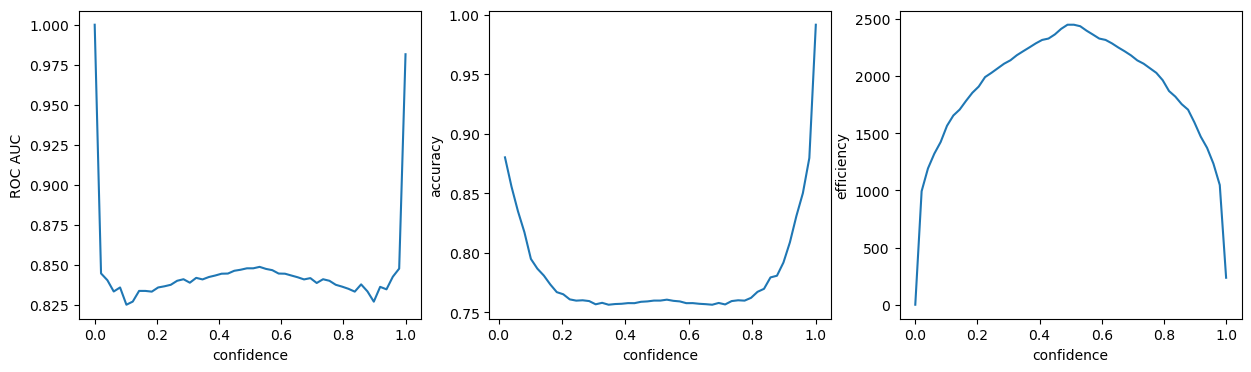

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

axes[0].plot(alpha, [roc_auc(l, p) if len(l) else 1. for l, p in zip(labels, preds)])
axes[0].set_xlabel('confidence')
axes[0].set_ylabel('ROC AUC')

axes[1].plot(alpha, [accuracy(l, p) for l, p in zip(labels, preds)])
axes[1].set_xlabel('confidence')
axes[1].set_ylabel('accuracy')

axes[2].plot(alpha, [len(l) for l in labels])
axes[2].set_xlabel('confidence')
axes[2].set_ylabel('efficiency')

plt.show()

## Uncertainty Prediction in Deep Learning

[1] Abdar, Moloud, et al. "A review of uncertainty quantification in deep learning: Techniques, applications and challenges." *Information Fusion* 76 (2021): 243-297.

![DL](dl_techniques.jpg)